Герен София БКЛ 223


Используя библиотеку синтаксического
анализа извлечь все названия организаций и адреса из текстов новостей. Построить граф социальной сети для организаций, упоминавшихся в новостях, считая, что организация и адрес, встретившиеся в одной заметке связаны между собой. Найти наиболее вероятные адреса организаций.


In [1]:
pip install natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=f19f8456c405e2cdea940a62f24c5b193fd3927a69f8265e38454a537fc4ed66
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=529a0b83d0d85ef3f617f5425e0182ad68118e84ba1bb6555b7bcb6f8ea2c9c0
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built docopt intervaltree


In [2]:
pip install fake-useragent

In [16]:
import requests
from pprint import pprint
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
import re
import pandas as pd
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
#import pygraphviz
import networkx as nx
import math
import numpy as np
import plotly.graph_objs as go

from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    ORG,
    AddrExtractor,
    Doc
)

In [4]:
session = requests.session()

In [5]:
ua = UserAgent()

In [6]:
headers = {'User-Agent': ua.random}
print(headers)
response = session.get('https://pravdasevera.ru', headers=headers)

{'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0'}


Парсим сайт с новостями

In [7]:
def parse_news_page_block(one_block):

    # функция достает текст одной ссылки

    href = one_block.attrs['href']
    url_o = 'https://pravdasevera.ru' + href

    req = session.get(url_o, headers={'User-Agent': ua.random})
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    full_text = soup.find('div', {'class' : 'block--article__text'}).text.replace('\xa0', ' ').replace('\n', ' ')

    return href, full_text


def get_nth_page(year, month, day):

    # функция загружает в словарь все тексты одного дня

    # скачиваем
    url = f'https://pravdasevera.ru/{year}/{month}/{day}/'
    req = session.get(url, headers={'User-Agent': ua.random})
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')

    # находим новости
    news = soup.find_all('a', {'class': 'nitem'})

    # идем по новостям и обрабатываем их
    blocks = {}
    for n in news:
        try:
            href, full_text = parse_news_page_block(n)
            blocks[href] = full_text
        except Exception as e:
            print(e)

    return blocks


def get_period_data(start, end):


    # функция загружает данные новостей за выбранный период

    date_dict = {}
    for date in pd.date_range(start, end, freq='D'):
        date = str(date)
        date_dict[date[:10]] = (date[:4], date[5:7], date[8:10])


    result = {}
    for date in tqdm(list(date_dict.keys())):
        try:
            page_dict = get_nth_page(*date_dict[date])
            result[date] = page_dict
        except:
            print(f'Ошибка в дате {date}')

    res = ''
    for date in result:
        for page in result[date]:
            text = result[date][page]
            res += text

    start = str(start)[:10].replace('-', '_')
    end = str(end)[:10].replace('-', '_')

    text_file = open(f"text_file_{start}_{end}.txt", "w")
    text_file.write(res)
    text_file.close()

    return result

In [8]:
x = get_period_data('2024-06-01', '2024-06-07') # выбираем период, по которым будем смотреть новости

100%|██████████| 7/7 [00:54<00:00,  7.83s/it]


In [9]:
# записываем все новости в список
news = []
for date in x:
  for page in x[date]:
    text = x[date][page]
    news.append(text)

In [11]:
# читаем файл с новостями по выбранному периоду
with open('text_file_2024_06_01_2024_06_07.txt', 'r', encoding='utf-8') as f:
    data = list(f)

In [12]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)

addr_extractor = AddrExtractor(morph_vocab) # создаем объект AddrExtractor

Получаем список всех локаций и всех организаций

In [13]:
data = []
for n in tqdm(news):
  doc = Doc(n)

  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  doc.tag_ner(ner_tagger)

  loc_lems = []
  org_lems = []
  for span1 in doc.spans:
      if span1.type == 'ORG':
          for tok in span1.tokens:
            tok.lemmatize(morph_vocab)
          org_lems.append(' '.join([tok.lemma for tok in  span1.tokens]))
      if span1.type == 'LOC':
          for tok in span1.tokens:
            tok.lemmatize(morph_vocab)
          loc_lems.append(' '.join([tok.lemma for tok in  span1.tokens]))

  loc_lems = list(set(loc_lems))
  org_lems = list(set(org_lems))
  if len(loc_lems) == 0 or len(org_lems) == 0:
    continue
  data.append([loc_lems, org_lems])


100%|██████████| 168/168 [00:27<00:00,  6.19it/s]


Строим в граф, в котором каждая организация связана с локацией

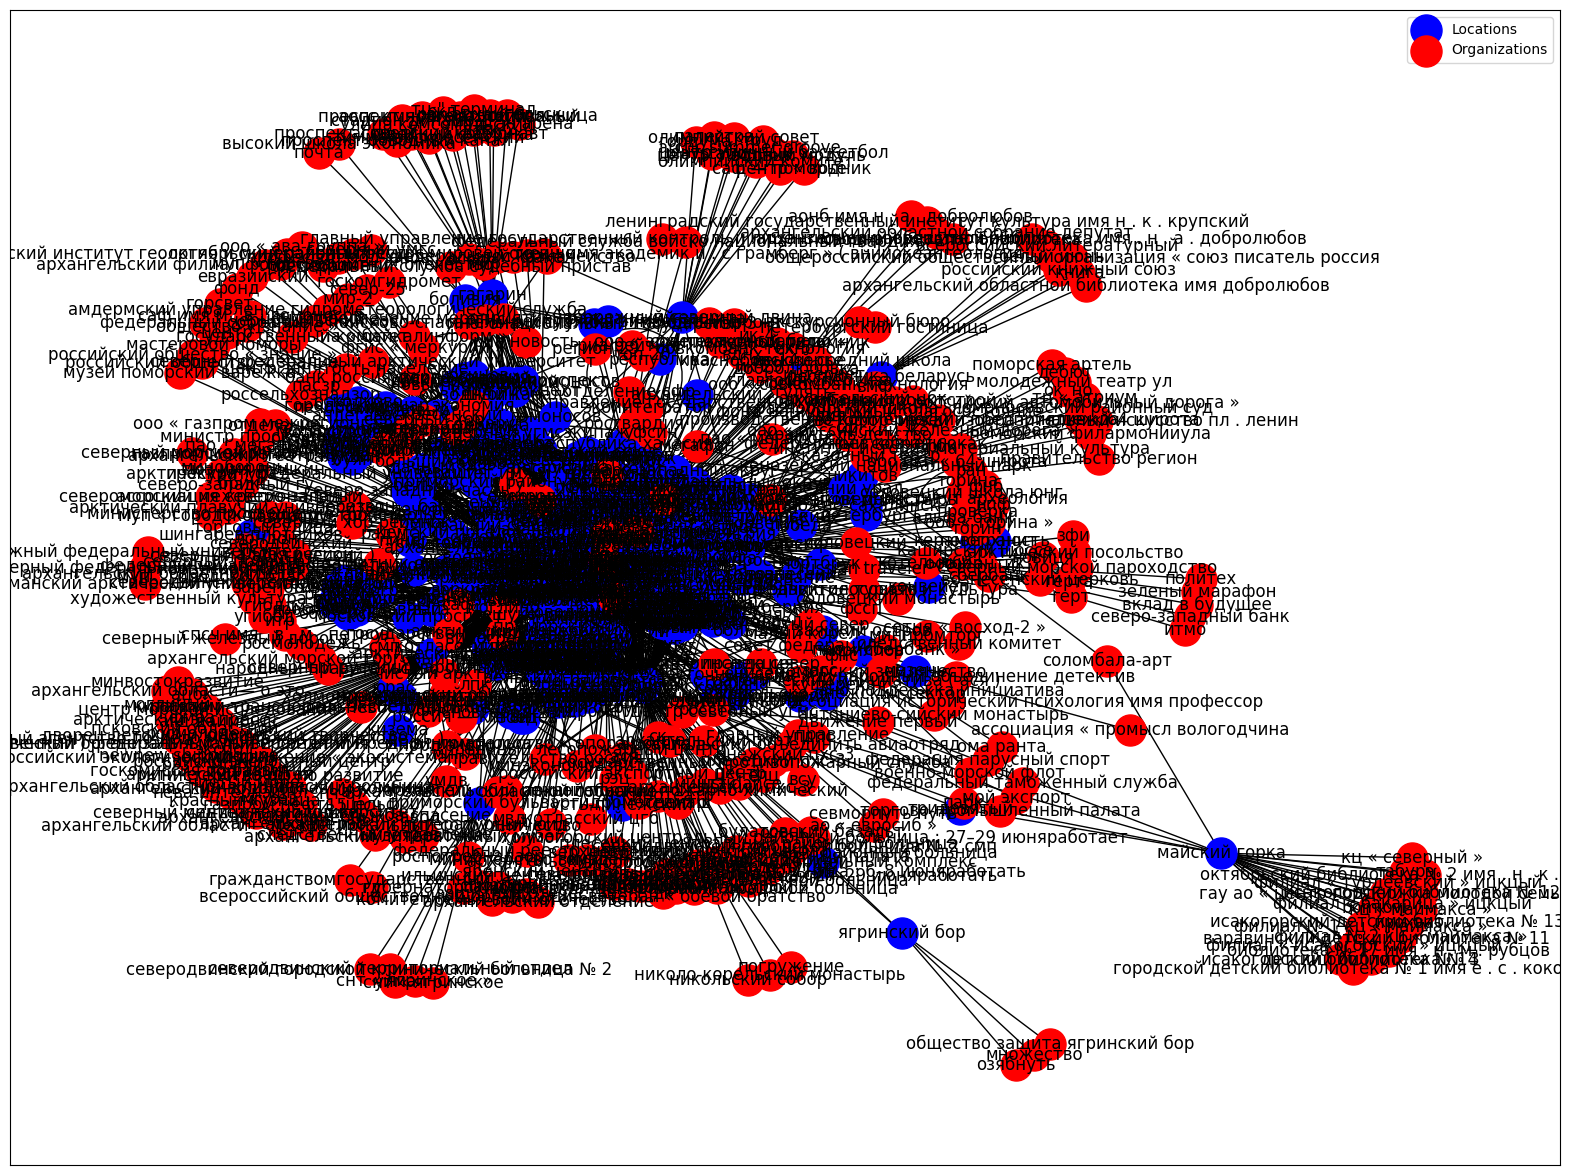

In [14]:
def build_graph(data):
    G = nx.Graph()

    for locations, organizations in data:
        # Добавляем узлы для локаций
        for loc in locations:
            G.add_node(loc, type='location')

        # Соединяем все локации между собой
        for i in range(len(locations)):
            for j in range(i + 1, len(locations)):
                G.add_edge(locations[i], locations[j])

        # Добавляем узлы для организаций и соединяем их с соответствующими локациями
        for org in organizations:
            G.add_node(org, type='organization')
            # Связываем организацию с первой локацией в списке
            G.add_edge(locations[0], org)

    return G

def draw_graph(G):
    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G)

    # Разделим узлы на локации и организации для разной визуализации
    location_nodes = [n for n, attrs in G.nodes(data=True) if attrs['type'] == 'location']
    organization_nodes = [n for n, attrs in G.nodes(data=True) if attrs['type'] == 'organization']

    # Отобразить узлы
    nx.draw_networkx_nodes(G, pos, nodelist=location_nodes, node_color='blue', node_size=500, label="Locations")
    nx.draw_networkx_nodes(G, pos, nodelist=organization_nodes, node_color='red', node_size=500, label="Organizations")

    # Отобразить ребра
    nx.draw_networkx_edges(G, pos)

    # Отобразить метки узлов
    nx.draw_networkx_labels(G, pos)

    plt.legend(loc='best')
    plt.show()

G = build_graph(data)
draw_graph(G)

Строим такой же граф, но уже интерактивный

In [17]:
pos = nx.spring_layout(G)
# Создаем список координат узлов
Xn = [pos[k][0] for k in pos.keys()]
Yn = [pos[k][1] for k in pos.keys()]

# Создаем список координат ребер
Xe = []
Ye = []
for e in G.edges():
    Xe.extend([pos[e[0]][0], pos[e[1]][0], None])
    Ye.extend([pos[e[0]][1], pos[e[1]][1], None])

edge_trace = go.Scatter(x=Xe, y=Ye, mode='lines', line=dict(color='gray', width=1))

node_trace = go.Scatter(x=Xn, y=Yn, mode='markers+text', text=list(G.nodes()), textposition='bottom center')

layout = go.Layout(title='Interactive Network Graph', showlegend=False, hovermode='closest')

fig = go.Figure(data=[edge_trace, node_trace], layout=layout)

fig.show()


Считаем меру кластерности для всех вершин графа



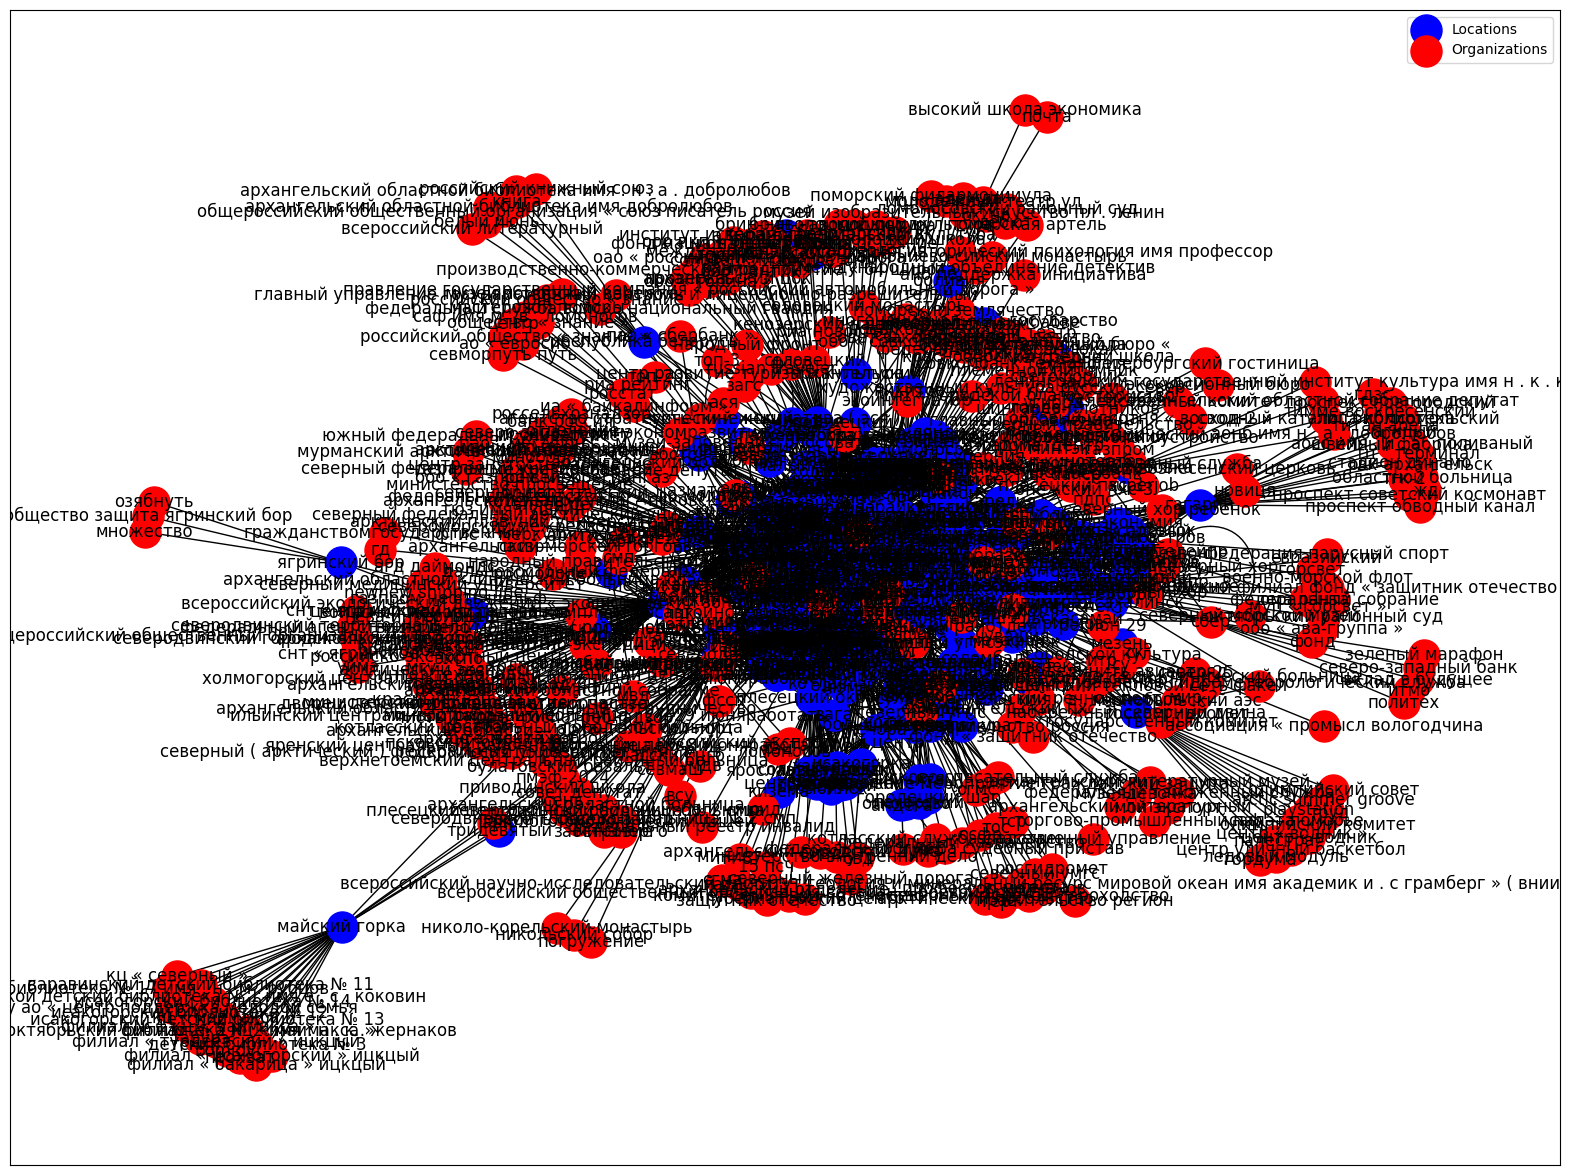

In [18]:
сс = nx.clustering(G)
gclr = [сс[i] for i in G.nodes()]
draw_graph(G)



"Взвесим" вершины, умножив их меру кластерности на логарифм от количества соседей.


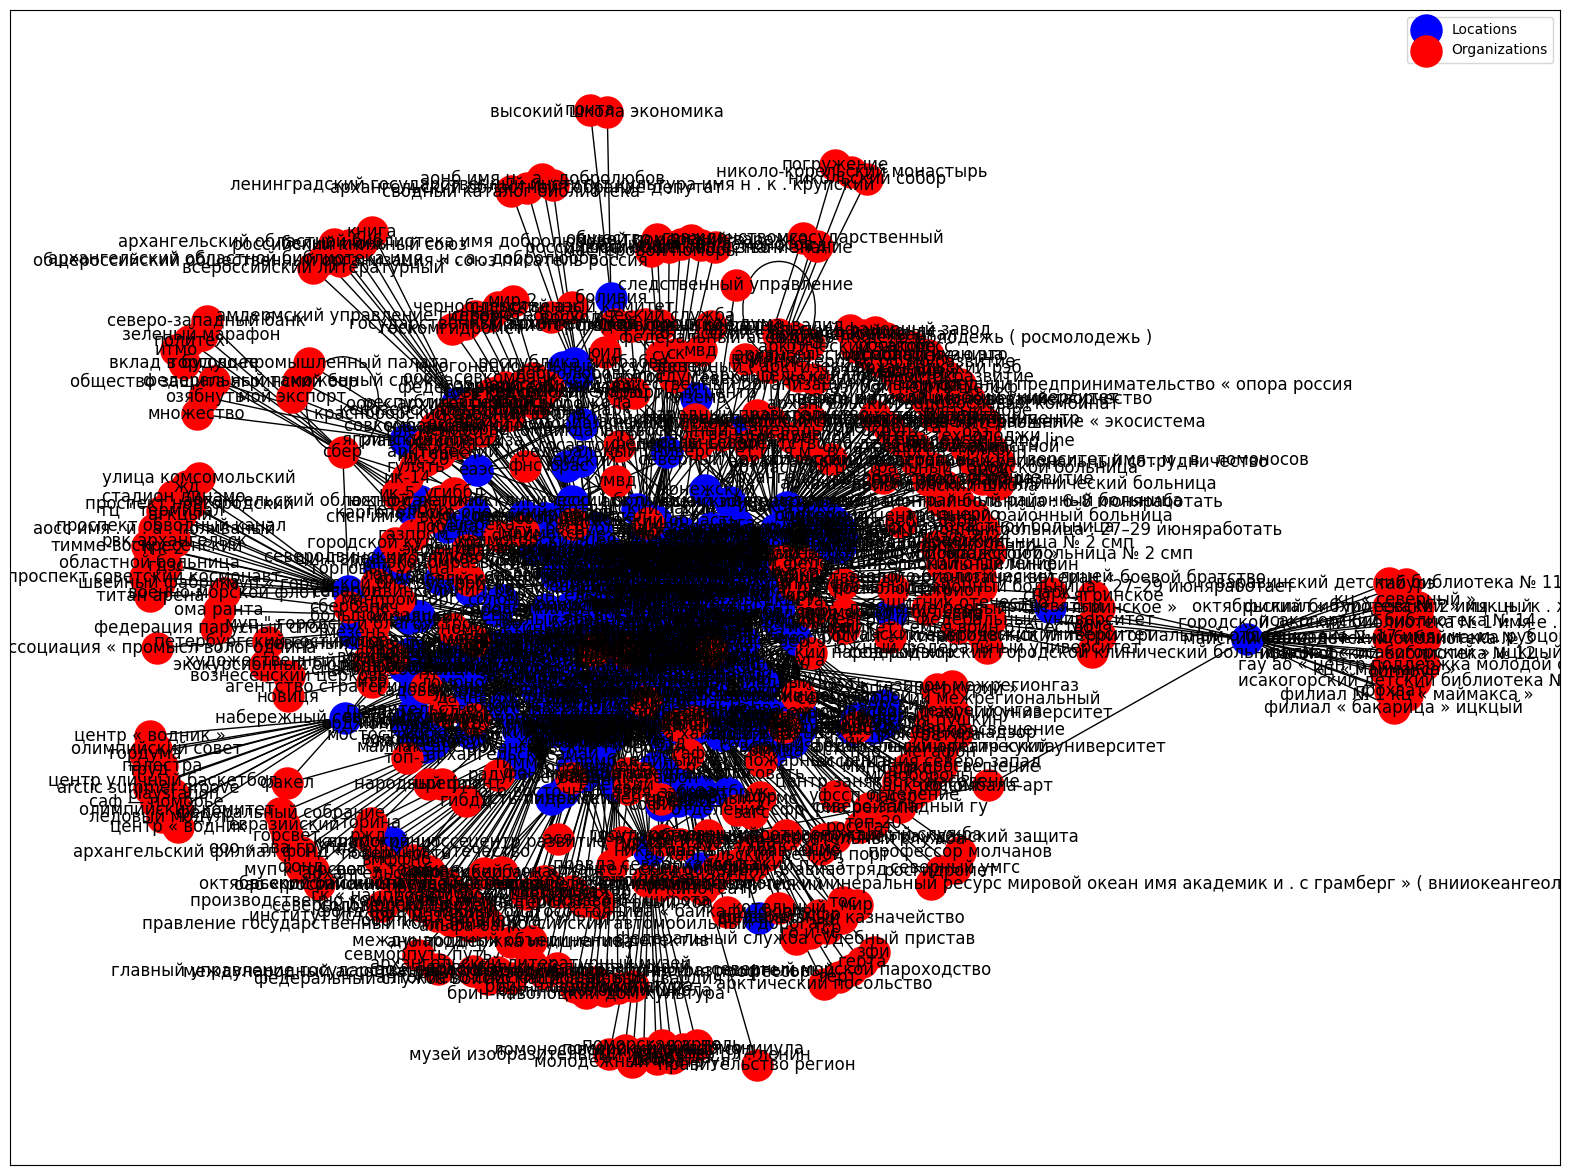

In [19]:
сс = nx.clustering(G)
gclr = [сс[i]*math.log(len(G[i].keys()))   for i in G.nodes()]
draw_graph(G)

Создадим словарь, в котором будут отражены локации, организации с которыми они связаны, и количество связей

In [20]:
def NER_it(text):
    doc = Doc(text)

    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    for s in doc.spans:
        s.tokens[-1].lemmatize(morph_vocab)
    return [(s.tokens[-1].lemma, s.type) for s in doc.spans]

def get_data(news, types = ['LOC', 'ORG']):

    names_all = {} # количества встречаний
    connect_all = {} # связи

    all_orgs = set()
    all_locs = set()

    for new in tqdm(news): # Перебираем все загруженные новости.
        nfacts = NER_it(new)     # Извлекаем именные группы из текста новости.

        loc_facts = [fact[0].split(" ")[-1] for fact in nfacts if fact[1] == 'LOC'] # извлекаем только места
        org_facts = [fact[0].split(" ")[-1] for fact in nfacts if fact[1] == 'ORG'] # извлекаем только организации

        loc_facts = list(set(loc_facts))
        org_facts = list(set(org_facts))


        for loc in loc_facts:
          all_locs.add(loc)
          names_all[loc] = names_all.get(loc, 0) + 1
          loc_conn = connect_all.get(loc, {})
          for org in org_facts:
              loc_conn[org] = loc_conn.get(org, 0) + 1
          connect_all[loc] = loc_conn

        for org in org_facts:
          all_orgs.add(org)
          names_all[org] = names_all.get(org, 0) + 1
          org_conn = connect_all.get(org, {})
          for loc in loc_facts:
              org_conn[loc] = org_conn.get(loc, 0) + 1
          connect_all[org] = org_conn

    return names_all, connect_all, list(all_orgs), list(all_locs)

def form_social_graph(places):
    # Добавляем дуги в граф. Вершины добавятся из названий дуг.
    G = nx.Graph()
    # Перебираем все найденные персоны.
    for n in places:
        for n2 in places[n]:
            # Собственно, добавляем дугу к графу. Вершины добавятся сами.
            G.add_edge(n, n2)

    return G

# Определим функцию отрисовки графа.
def draw_social_graph(G, places, freqs, colors='b', layout='spring'):
    # Строим расположение вершин графа на плоскости.
    if layout == 'kawai':
        pstn = nx.kamada_kawai_layout(G)
    elif layout == 'circle':
        pstn = nx.drawing.layout.circular_layout(G)
    elif layout == 'random':
        pstn = nx.drawing.layout.random_layout(G)
    else:
        pstn = nx.spring_layout(G)
    # Размер вершины зависит от частоты упоминания.
    sz = [freqs[n] for n in G.nodes]
    # Толщина линии дуги зависит от логарифма частоты совместной встречаемости участников новости.
    lw = [math.log(places[e[0]][e[1]], 10) + 1 for e in G.edges]
    # Рисуем граф.
    nx.draw(G, pos=pstn, node_color=colors, edge_color='g', with_labels=True, node_size=sz, width=lw);

In [21]:
names_all, connect_all, all_orgs, all_locs = get_data(news)

100%|██████████| 168/168 [00:21<00:00,  7.82it/s]


проверяем, что локация есть у организации, а у локации организация

In [22]:
for i in all_orgs:
  assert i in connect_all
for i in all_locs:
  assert i in connect_all

for i in connect_all:
  for j in connect_all[i]:
    assert i in connect_all[j]

In [25]:
max_n = 5 # отбираем только часто встречающиеся связи

res_dict = {n:{n2:connect_all[n][n2] for n2 in connect_all[n].keys() if names_all[n2] > max_n and n2 != ')'}
            for n in connect_all.keys() if names_all[n]> max_n and n!=')'}

Рисуем граф, в котором связаны города и организации

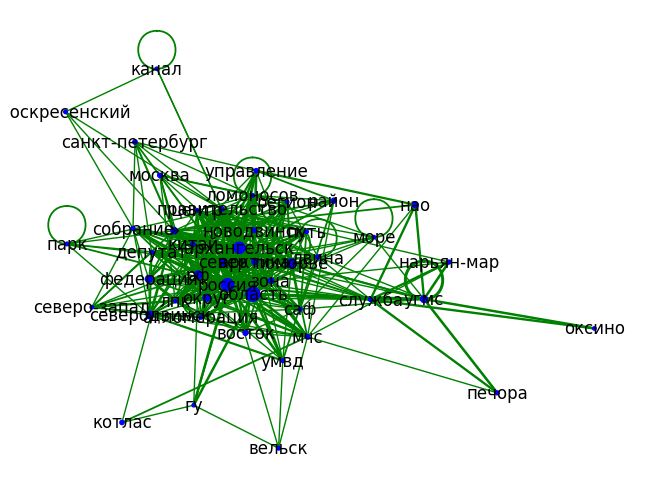

In [27]:
G1 = form_social_graph(res_dict)
draw_social_graph(G1, res_dict, names_all)

Ищем самый вероятный адрес для организации

In [28]:
best_adr = {}
for org in all_orgs:
  max_ = 0
  result_adr = None
  adrs = connect_all[org]
  for adr in adrs:
    if adrs[adr] > max_:
      result_adr = adr
      max_ = adrs[adr]
  best_adr[org] = result_adr

In [29]:
best_adr

{'центр': 'область',
 'ржд': 'москва',
 'аэс': 'ссср',
 'сотрудничество': 'кнр',
 'литературный': 'россия',
 'перезвон': 'санкт-петербург',
 '3': 'горка',
 'прохват': 'горка',
 'депутат': 'область',
 'межрегионгаз': 'рф',
 'путь': 'правительство',
 'госавтоинспекция': 'область',
 'благоустройство': 'архангельск',
 'это': 'кнр',
 'правительство': 'область',
 'водник': 'двина',
 'цгб': 'северодвинск',
 'экоинтегратор': 'область',
 'сгма': 'округ',
 'хор': 'архангельск',
 'авиаотряд': 'авиагруппа',
 'пдпс': 'поморье',
 'технология': 'россия',
 'ран': 'москва',
 'загс': 'область',
 'осфр': 'область',
 'модуль': 'двина',
 'квартал': 'восток',
 'культура': 'федерация',
 'управление': 'область',
 'законодатель': 'россия',
 'музей-заповедник': 'музей-заповедник',
 'пристав': 'нао',
 'моглино': 'моглино',
 'спасение': 'область',
 'книга': 'беларусь',
 'росгвардия': 'округ',
 'динамо': 'гагарин',
 'палестра': 'двина',
 'университет': 'зона',
 'областной': 'россия',
 'пхс-3': 'авиагруппа',
 'гдзс

**Гипотеза: две организации связаны, если они упоминаются вместе (в одной новости)**

Вычленяем только организации

In [30]:
def get_orgs(data):
    all_orgs = {}
    all_connect = {}
    for smt in tqdm(data):
        norgs = NER_it(smt)
        org = [fact[0].split(" ")[-1] for fact in norgs if fact[1] == 'ORG']
        sorg = list(set(org))
        for n in sorg:
            all_orgs[n] = all_orgs.get(n, 0) + 1
            orgs = all_connect.get(n, {})
            for n2 in sorg:
                if n != n2:
                    orgs[n2] = orgs.get(n2, 0) + 1
            all_connect[n] = orgs
    return all_orgs, all_connect

In [31]:
all_orgs, all_connect = get_orgs(news)

100%|██████████| 168/168 [00:26<00:00,  6.40it/s]


In [32]:
all_orgs

{'госкомгидромет': 1,
 'аэс': 1,
 'сибирь': 1,
 'дума': 5,
 'госдума': 4,
 'служба': 8,
 'север-25': 1,
 'комитет': 3,
 'путь': 2,
 'мир-2': 1,
 'ковчег': 1,
 'ик-29': 1,
 'ик-4': 1,
 'ик-14': 1,
 'ик-5': 1,
 'уфсин': 5,
 'театр': 1,
 'управление': 10,
 '»': 20,
 'росгвардия': 3,
 'штаб': 1,
 'пч-87': 1,
 'гу': 6,
 'мчс': 11,
 'спасение': 1,
 'псч': 2,
 'молодежь': 3,
 'регион': 4,
 'саф': 7,
 'университет': 3,
 'арктика': 5,
 'лпк': 6,
 'рэб': 1,
 'минвостокразвитие': 2,
 'правительство': 11,
 'кузница': 1,
 'защита': 5,
 'угмс': 16,
 'огмс': 5,
 'больница': 4,
 'зона': 2,
 'квартал': 1,
 'нева-интернэшнл': 1,
 'творчество': 1,
 'фмба': 1,
 'развитие': 1,
 'ицкцый': 1,
 'семья': 1,
 '14': 1,
 'прохват': 1,
 'bomjovi': 1,
 'первый': 3,
 'парк': 2,
 'рубцов': 1,
 'жернаков': 1,
 'табурэ': 1,
 '11': 1,
 '12': 1,
 'коковин': 1,
 '13': 1,
 '3': 1,
 'соломбала-арт': 2,
 'север': 8,
 'поморы': 1,
 'центр': 7,
 ')': 5,
 'знание': 1,
 'варежка': 1,
 'ломоносов': 3,
 'депутат': 7,
 'областной':

In [34]:
max_n = 2  # отбираем только часто встречающиеся связи

orgs2 = {n:{n2:all_connect[n][n2] for n2 in all_connect[n].keys() if all_orgs[n2] > max_n and n2 != ')'}
            for n in all_connect.keys() if all_orgs[n]>max_n and n!=')'}
orgs2

{'дума': {'госдума': 2,
  'служба': 1,
  'комитет': 1,
  'управление': 1,
  'умвд': 1,
  'собрание': 2},
 'госдума': {'дума': 2,
  'служба': 1,
  'комитет': 1,
  'собрание': 2,
  'депутат': 1,
  'областной': 1,
  '»': 1},
 'служба': {'дума': 1,
  'госдума': 1,
  'комитет': 1,
  'защита': 5,
  'угмс': 5,
  'огмс': 5,
  'центр': 2,
  'лпк': 1,
  'управление': 1,
  'мчс': 1},
 'комитет': {'дума': 1,
  'госдума': 1,
  'служба': 1,
  'собрание': 1,
  '29': 1,
  '»': 2,
  'мчс': 1},
 'уфсин': {'собрание': 1, 'правительство': 1, 'сво': 1, 'север': 1},
 'управление': {'»': 2,
  'росгвардия': 3,
  'дума': 1,
  'умвд': 1,
  'лпк': 1,
  'центр': 1,
  'служба': 1,
  'мчс': 1},
 '»': {'управление': 2,
  'росгвардия': 1,
  'первый': 1,
  'молодежь': 1,
  'центр': 1,
  'регион': 2,
  'ломоносов': 1,
  'собрание': 2,
  '29': 1,
  'комитет': 2,
  'школа': 1,
  'саф': 1,
  'мегафон': 4,
  'правительство': 2,
  'роспотребнадзор': 1,
  'мчс': 1,
  'депутат': 1,
  'госдума': 1,
  'областной': 1},
 'росгвар

Рисуем граф, в котором связаны только организации друг с другом

In [35]:
G2 = form_social_graph(orgs2)

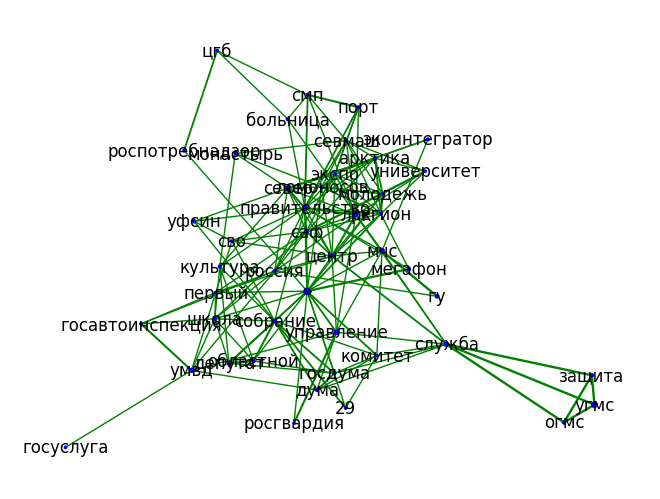

In [36]:
draw_social_graph(G2, orgs2, all_orgs)